# Digit Recognizer
**MNIS** ("*Modified National Institute of Standards and Technology*") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms.

### Image Description
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

### Dataset Info
The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = torch.device('cpu')
device

device(type='cpu')

In [3]:
class CustomMNISTDataset(Dataset):
    
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test
    
    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        item = self.data_frame.iloc[index]

        if self.is_test:
            image = item.values.reshape(28, 28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28, 28).astype(np.uint8)
            label = item.iloc[0]

        image = transforms.ToPILImage()(image)

        if self.transform is not None:
            image = self.transform(image)
        
        if self.is_test:
            return image
        else:
            return image, label

In [4]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [5]:
train_dataset = CustomMNISTDataset('./../datasets/digit-recognizer-train.csv', transform=transform, is_test=False)
test_dataset = CustomMNISTDataset('./../datasets/digit-recognizer-test.csv', transform=transform, is_test=True)

In [6]:
print('Train Size:', len(train_dataset), ', Test Size:', len(test_dataset))

Train Size: 42000 , Test Size: 28000


In [7]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [8]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Input Size: torch.Size([1, 28, 28])
Input Size: (28, 28, 1)


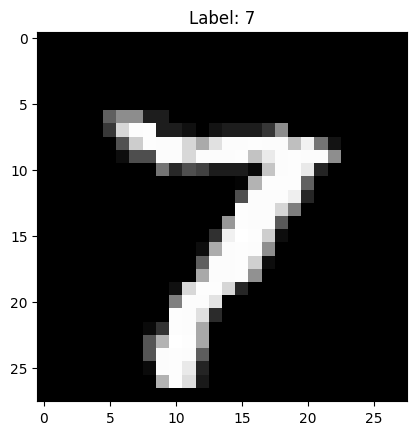

In [9]:
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print('Input Size:', example_image.size())

    example_image_numpy = example_image.permute(1, 2, 0).numpy()
    print('Input Size:', example_image_numpy.shape)

    plt.imshow(example_image_numpy.squeeze(), cmap='gray')
    plt.title(f'Label: {example_labels[0]}')
    plt.show()

    break


In [10]:
class DigitCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 20)
        self.fc3 = nn.Linear(20, 10)

        self.conv_layers = nn.Sequential(
            self.conv1,
            self.relu,
            self.pool,

            self.conv2,
            self.relu,
            
            self.conv3,
            self.pool,
        )

        self.linear_layers = nn.Sequential(
            self.fc1,
            self.relu,
            self.fc2,
            self.fc3
        )

    def forward(self, x):
        x = self.conv_layers(x)

        # Update input form
        x_size = x.size(1) * x.size(2) * x.size(3)
        x = x.view(-1, x_size)

        return self.linear_layers(x)
       


In [11]:
model = DigitCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [12]:
n_epochs = 100
running_loss = 0.0

for epoch in range(n_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data 
        optimizer.zero_grad()

        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if i % 100 == 99:
            print(f'[{epoch + 1}, {i + 1}] Loss: {running_loss / 100:.3f}')
            running_loss = 0.0
            
print('Training finished')

[1, 100] Loss: 2.301
[1, 200] Loss: 2.287
[1, 300] Loss: 2.260
[1, 400] Loss: 2.182
[1, 500] Loss: 1.771
[1, 600] Loss: 0.924
[2, 100] Loss: 0.894
[2, 200] Loss: 0.455
[2, 300] Loss: 0.396
[2, 400] Loss: 0.377
[2, 500] Loss: 0.335
[2, 600] Loss: 0.338
[3, 100] Loss: 0.459
[3, 200] Loss: 0.282
[3, 300] Loss: 0.254
[3, 400] Loss: 0.230
[3, 500] Loss: 0.222
[3, 600] Loss: 0.197
[4, 100] Loss: 0.301
[4, 200] Loss: 0.185
[4, 300] Loss: 0.169
[4, 400] Loss: 0.152
[4, 500] Loss: 0.144
[4, 600] Loss: 0.144
[5, 100] Loss: 0.211
[5, 200] Loss: 0.136
[5, 300] Loss: 0.129
[5, 400] Loss: 0.123
[5, 500] Loss: 0.120
[5, 600] Loss: 0.117
[6, 100] Loss: 0.177
[6, 200] Loss: 0.102
[6, 300] Loss: 0.098
[6, 400] Loss: 0.107
[6, 500] Loss: 0.097
[6, 600] Loss: 0.104
[7, 100] Loss: 0.145
[7, 200] Loss: 0.086
[7, 300] Loss: 0.085
[7, 400] Loss: 0.081
[7, 500] Loss: 0.088
[7, 600] Loss: 0.081
[8, 100] Loss: 0.128
[8, 200] Loss: 0.078
[8, 300] Loss: 0.077
[8, 400] Loss: 0.079
[8, 500] Loss: 0.077
[8, 600] Loss

In [13]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        outputs = model(data)

        _, pred = torch.max(outputs, 1)
        predictions.extend(pred.tolist())

submission = pd.DataFrame({
    'ImageId' : range(1, len(predictions) + 1),
    'Label': predictions
})

submission.to_csv('./../submissions/digit-recognizer-submission.csv', index=False)